In [ ]:
# import os

# os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

from typing import Tuple

import diffrax
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jaxtyping import Array, ArrayLike

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments.examples as examples
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers

In [ ]:
environment = examples.ApoptosisEnvironment(
    "../data/Initial_concentrations_CD95H_wtH.mat", [0, 500], 50
)
state = environment.init()
control = controls.LambdaControl(lambda x: jnp.ones((2,)))
key = jax.random.PRNGKey(1234)

for i in range(5):
    seq = environment.integrate(control, state, key)

jit_integrate = eqx.filter_jit(environment.integrate)
for i in range(5):
    seq = jit_integrate(control, state, key)

with jax.profiler.trace("/tmp/jax-trace", create_perfetto_trace=True):
    seq = environment.integrate(control, state, key)
    jit_integrate(control, state, key)

In [ ]:
# Training

key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
control = controls.ImplicitControl(controls.Siren(1, 1, 32, 2, subkey), 0.0, 180.0)

solver = solvers.DirectSolver()
environment = examples.ApoptosisEnvironment(
    "../data/Initial_concentrations_CD95H_wtH.mat", [0, 500], 50
)


def reward_fn(args: Tuple[Array, Array]):
    ys, thresh = args
    reward = jnp.mean(
        jnp.clip(
            ys[..., 12] / (ys[..., 3] + ys[..., 12]),
            a_min=None,
            a_max=thresh.reshape(-1, 1),
        )
    )
    return reward


@jax.jit
def train_with_integral(
    integral: ArrayLike,
) -> Tuple[ArrayLike, controls.AbstractControl]:
    constraint = constraints.NonNegativeConstantIntegralConstraint(integral)
    return trainers.solve_optimal_control_problem(
        environment, reward_fn, [constraint], solver, control, 256, key
    )


reward, control = train_with_integral(jnp.asarray([10.0]))

In [ ]:
constraint = constraints.NonNegativeConstantIntegralConstraint(jnp.asarray([10.0]))

t = jnp.linspace(0.0, 100.0, 1024).reshape(-1, 1)
signal = jax.vmap(control)(t)
constrained_signal = constraint.transform(signal)

fig, ax = plt.subplots(1, 1, sharex=True)
ax.plot(t, signal)
ax.plot(t, constrained_signal)
plt.show()

In [ ]:
state = environment.init()

# Evaluate control
full_control = jax.vmap(control)(
    jnp.linspace(control.t_start, control.t_end, 1024).reshape(1024, 1)
)

# Transform control
full_control = constraint.transform(full_control)

# Package control
cached_control = controls.InterpolationControl(
    full_control.shape[1],
    full_control.shape[0],
    control.t_start,
    control.t_end,
    method="step",
    control=full_control,
)


@eqx.filter_jit
# @eqx.filter_grad
def integrate(params, static) -> Tuple[Array, Array]:
    cached_control = eqx.combine(params, static)
    ys, thresh = environment.integrate(cached_control, state, key)

    return jnp.mean(ys)


@eqx.filter_jit
# @eqx.filter_grad
def _integrate(params, static, y0: Array) -> Array:
    cached_control = eqx.combine(params, static)
    terms = diffrax.ODETerm(examples.apoptosis_ode)
    solver = diffrax.Dopri5()

    sol = diffrax.diffeqsolve(
        terms=terms,
        solver=solver,
        t0=0.0,
        t1=180.0,  # Minutes
        dt0=1.0,
        y0=y0,
        args=cached_control,
        saveat=diffrax.SaveAt(ts=jnp.linspace(0.0, 180.0, 181)),
        max_steps=181,
        adjoint=diffrax.RecursiveCheckpointAdjoint(checkpoints=181),
    )

    return jnp.mean(sol.ys)

In [ ]:
x0, _ = environment._sample_x0(state, key)
params, static = eqx.partition(cached_control, eqx.is_array)

integrate(params, static)
_integrate(params, static, x0[0])

%timeit integrate(params, static)
%timeit _integrate(params, static, x0[0])

In [ ]:
state.x0[..., -1]

In [ ]:
frac = ys[..., 12] / (ys[..., 3] + ys[..., 12])
# thresh = state.x0[..., -1] * 1.4897

plt.figure()
for t in thresh:
    plt.axhline(t, c="black")
plt.plot(frac.T)
plt.show()

plt.figure()
plt.plot(control.control)
plt.show()

# Adaptively sampling over integrals

In [ ]:
import jax

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

import time
from functools import partial
from typing import Callable, Tuple

import diffrax
import equinox as eqx
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from adaptive import Learner1D, notebook_extension
from IPython.display import clear_output
from jaxtyping import Array, ArrayLike
from tqdm.auto import tqdm as tq
from tqdm.auto import trange

import optimal_control.constraints as constraints
import optimal_control.controls as controls
import optimal_control.environments as environments
import optimal_control.environments.examples as examples
import optimal_control.solvers as solvers
import optimal_control.trainers as trainers

notebook_extension()

In [73]:
# Training

key = jax.random.PRNGKey(1234)

key, subkey = jax.random.split(key)
control = controls.ImplicitControl(controls.Siren(1, 1, 32, 2, subkey), 0.0, 180.0)
solver = solvers.DirectSolver(optax.adamw(learning_rate=1e-4), num_control_points=10)

mat_path = "../data/Initial_concentrations_CD95H_wtH.mat"
train_environment = examples.ApoptosisEnvironment(mat_path, [0, 500], 50)
val_environment = examples.ApoptosisEnvironment(mat_path, [500, 1000], 500, True)
val_env_state = val_environment.init()


def reward_fn(args: Tuple[Array, Array]):
    ys, thresh = args
    reward = jnp.mean(
        jnp.clip(
            ys[..., 12] / (ys[..., 3] + ys[..., 12]),
            a_min=None,
            a_max=thresh.reshape(-1, 1),
        )
    )
    return reward


@eqx.filter_jit
def train_with_integral(
    integral: ArrayLike, environment: examples.ApoptosisEnvironment
) -> Tuple[ArrayLike, controls.AbstractControl]:
    constraint = constraints.NonNegativeConstantIntegralConstraint(integral)
    return trainers.solve_optimal_control_problem(
        environment, reward_fn, [constraint], solver, control, 256, key
    )


def build_control(
    integral: ArrayLike,
    control: controls.AbstractControl,
) -> controls.AbstractControl:
    constraint = constraints.NonNegativeConstantIntegralConstraint(integral)

    # Evaluate control
    num_points = 10
    points = jnp.linspace(
        control.t_start, control.t_end, num=num_points, endpoint=False
    )
    spacing = (control.t_end - control.t_start) / num_points
    points += spacing / 2

    # Transform control
    full_control = jax.vmap(control)(points.reshape(num_points, 1))
    full_control = constraint.transform(full_control)

    # Package control
    control = controls.InterpolationControl(
        full_control.shape[1],
        full_control.shape[0],
        control.t_start,
        control.t_end,
        method="step",
        control=full_control,
    )

    return control, points


@eqx.filter_jit
def evaluate(
    integral: ArrayLike,
    control: controls.AbstractControl,
    environment: examples.ApoptosisEnvironment,
) -> ArrayLike:
    control, _ = build_control(integral, control)

    environment_state = environment.init()
    env_seq = environment.integrate(control, environment_state, key)
    reward = reward_fn(env_seq)

    return reward


@eqx.filter_jit
def integrate(
    control: controls.AbstractControl,
    environment: examples.ApoptosisEnvironment,
    environment_state: examples.ApoptosisState,
) -> ArrayLike:
    env_seq = environment.integrate(control, environment_state, key)

    return env_seq


# reward, control = train_with_integral(jnp.asarray([10.0]))

In [ ]:
learner = Learner1D(lambda x: 0, bounds=(-5, 5))

plot_timer = time.time()
plot_interval = 15
results = []
while True:
    x, _ = learner.ask(1)
    x = x[0]

    integral = jnp.asarray([x], dtype=jnp.float64)
    integral = 10**integral

    optimized_reward, optimized_control = train_with_integral(
        integral, train_environment
    )
    val_reward = evaluate(integral, optimized_control, val_environment)

    learner.tell(x, float(val_reward))
    results.append(
        {
            "x": x,
            "integral": integral,
            "optimized_reward": optimized_reward,
            "optimized_control": optimized_control,
            "val_reward": val_reward,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(learner.plot())

In [ ]:
# Save results

import pickle

pickle_results = {"learner": learner, "results": results}
with open("../results/apoptosis/piecewise_constant_optim.pickle", mode="wb") as f:
    pickle.dump(pickle_results, f)

In [ ]:
# Load results

import pickle

with open(
    "../results/apoptosis/piecewise_implicit/piecewise_constant_optim.pickle", mode="rb"
) as f:
    pickle_results = pickle.load(f)

learner, results = pickle_results["learner"], pickle_results["results"]

# Adaptive with constant integrals

In [ ]:
@eqx.filter_jit
def evaluate(
    control: controls.AbstractControl,
    environment: examples.ApoptosisEnvironment,
    environment_state: examples.ApoptosisState,
) -> ArrayLike:
    env_seq = environment.integrate(control, environment_state, key)
    reward = reward_fn(env_seq)

    return reward

In [ ]:
def copy_data(t, c):
    return c

In [ ]:
constant_learner = Learner1D(lambda x: 0, bounds=(-5, 5))


plot_timer = time.time()
plot_interval = 15
constant_results = []
while True:
    x, _ = constant_learner.ask(1)
    x = x[0]

    integral = jnp.asarray([x], dtype=jnp.float64)
    integral = 10**integral

    constant_control = controls.LambdaControl(copy_data, data=integral)
    val_reward = evaluate(constant_control, val_environment, val_env_state)

    constant_learner.tell(x, float(val_reward))
    constant_results.append(
        {
            "x": x,
            "integral": integral,
            "val_reward": val_reward,
        }
    )

    if time.time() - plot_timer >= plot_interval:
        plot_timer = time.time()

        clear_output(wait=True)
        display(constant_learner.plot())

In [ ]:
# Save results

import pickle

pickle_results = {"learner": constant_learner, "results": constant_results}
with open("../results/apoptosis/piecewise_constant_fixed.pickle", mode="wb") as f:
    pickle.dump(pickle_results, f)

In [ ]:
# Load results

import pickle

with open(
    "../results/apoptosis/piecewise_implicit/piecewise_constant_fixed.pickle", mode="rb"
) as f:
    pickle_results = pickle.load(f)

constant_learner, constant_results = (
    pickle_results["learner"],
    pickle_results["results"],
)

# Plots

In [ ]:
reaction_volume = 0.8  # ml
concentration_to_moles = 16.6 / 500  # 16.6nM = 500ng/ml

output_folder = "/home/lena/master-thesis/repos/optimal-control/results/apoptosis/poster"
plt_style = "seaborn-poster"

In [ ]:
from typing import Any, Optional, Tuple

from matplotlib.axis import Axis

In [ ]:
def plt_handle_output(
    figure_filepath: str,
    *,
    show: bool = True,
    save: bool = False,
    output_folder: str = "",
):
    if save:
        plt.savefig(f"{output_folder}/{figure_filepath}.png", bbox_inches="tight")
        plt.savefig(f"{output_folder}/{figure_filepath}.svg", bbox_inches="tight")

    if show:
        plt.show()
    else:
        plt.close()

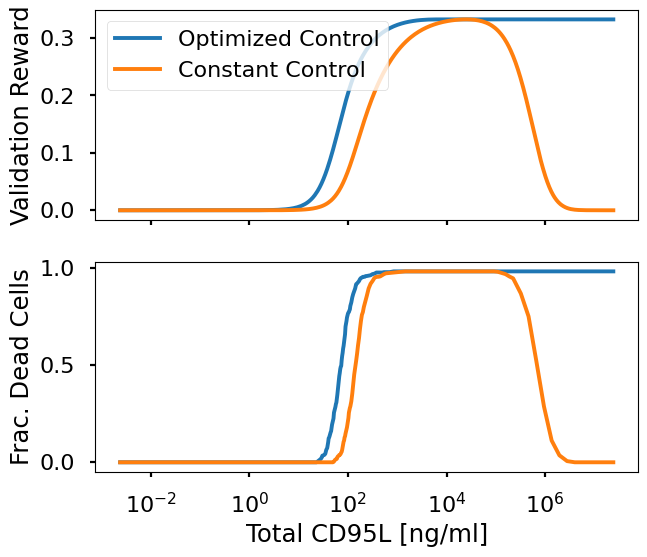

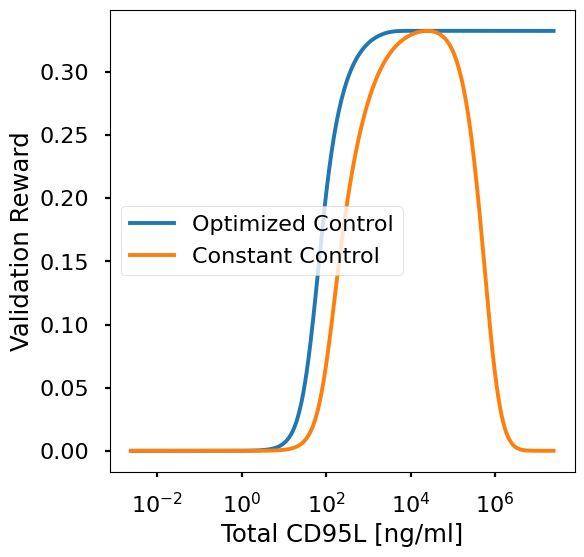

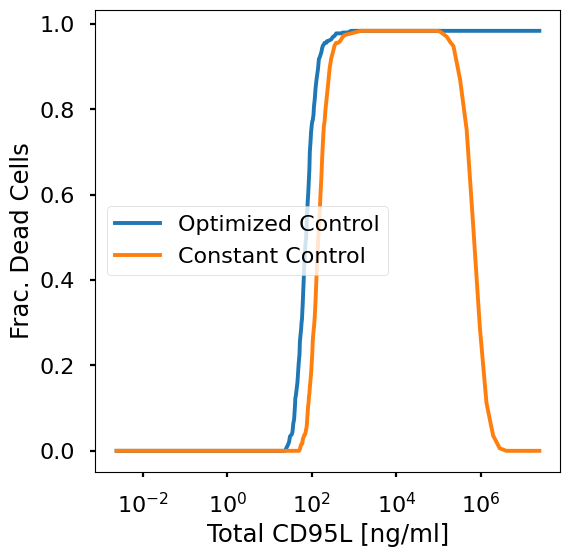

In [75]:
# Reward vs. Integral of optimized and constant controls


def plot_direct_control_figures(
    opt_results,
    const_results,
    type: str = "reward",
    ax: Optional[Any] = None,
    *,
    show: bool = True,
    save: bool = False,
    output_folder: str = "",
):
    def get_xy(type: str) -> Tuple[np.ndarray, np.ndarray]:
        def get_cell_frac(control: controls.AbstractControl) -> float:
            ys, tbid_thresh = val_environment.integrate(control, val_env_state, key)
            tbid_frac = ys[:, -1, 12] / (ys[:, -1, 3] + ys[:, -1, 12])
            cell_frac = jnp.mean(
                jnp.where(
                    tbid_frac > tbid_thresh,
                    jnp.ones_like(tbid_frac),
                    jnp.zeros_like(tbid_frac),
                )
            )

            return cell_frac

        if type == "reward":
            opt_xy = np.asarray([(r["x"], r["val_reward"]) for r in opt_results])
            opt_xy = opt_xy[np.argsort(opt_xy[:, 0])]

            const_xy = np.asarray([(r["x"], r["val_reward"]) for r in const_results])
            const_xy = const_xy[np.argsort(const_xy[:, 0])]
        elif type == "cells":
            opt_xy = []
            for result in opt_results:
                x = result["x"]

                integral = jnp.asarray([x], dtype=jnp.float64)
                integral = 10**integral

                control = result["optimized_control"]
                control, _ = build_control(integral, control)
                cell_frac = get_cell_frac(control)

                opt_xy.append((x, cell_frac))

            opt_xy = np.asarray(opt_xy)
            opt_xy = opt_xy[np.argsort(opt_xy[:, 0])]

            const_xy = []
            for result in opt_results:
                x = result["x"]

                integral = jnp.asarray([x], dtype=jnp.float64)
                integral = 10**integral

                control = controls.LambdaControl(
                    copy_data, data=jnp.full((1,), integral)
                )
                cell_frac = get_cell_frac(control)

                const_xy.append((x, cell_frac))

            const_xy = np.asarray(const_xy)
            const_xy = const_xy[np.argsort(const_xy[:, 0])]

        return opt_xy, const_xy

    if type == "reward" or type == "cells":
        opt_xy, const_xy = get_xy(type)

        plt.figure(figsize=(6, 6))
        # plt.xlabel(r"$\log_{10} \int_{t_0}^{t_1} c(t)dt$")
        plt.xlabel("Total CD95L [ng/ml]")
        plt.ylabel("Validation Reward" if type == "reward" else "Frac. Dead Cells")

        plt.xscale("log")
        plt.plot(
            10 ** opt_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            opt_xy[:, 1],
            label="Optimized Control",
        )
        plt.plot(
            10 ** const_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            const_xy[:, 1],
            label="Constant Control",
        )
        plt.legend()
        plt_handle_output(
            f"piecewise_implicit/{type}_vs_integral_comparison",
            show=show,
            save=save,
            output_folder=output_folder,
        )
    elif type == "both":
        reward_opt_xy, reward_const_xy = get_xy("reward")
        cells_opt_xy, cells_const_xy = get_xy("cells")

        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(7, 6))

        ax[0].set_ylabel("Validation Reward")
        ax[1].set_ylabel("Frac. Dead Cells")

        ax[1].set_xlabel("Total CD95L [ng/ml]")
        ax[1].set_xscale("log")

        ax[0].plot(
            10 ** reward_opt_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            reward_opt_xy[:, 1],
            label="Optimized Control",
        )
        ax[0].plot(
            10 ** reward_const_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            reward_const_xy[:, 1],
            label="Constant Control",
        )

        ax[1].plot(
            10 ** cells_opt_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            cells_opt_xy[:, 1],
            label="Optimized Control",
        )
        ax[1].plot(
            10 ** cells_const_xy[:, 0] * reaction_volume / concentration_to_moles * 10,
            cells_const_xy[:, 1],
            label="Constant Control",
        )

        ax[0].legend()

        plt_handle_output(
            f"piecewise_implicit/both_vs_integral_comparison",
            show=show,
            save=save,
            output_folder=output_folder,
        )


import matplotlib

with plt.style.context(plt_style):
    plot_direct_control_figures(
        results, constant_results, type="both", save=True, output_folder=output_folder
    )
    plot_direct_control_figures(
        results, constant_results, type="reward", save=True, output_folder=output_folder
    )
    plot_direct_control_figures(
        results, constant_results, type="cells", save=True, output_folder=output_folder
    )

In [ ]:
# Individual optimized controls at relevant points on the reward curve

with plt.style.context("seaborn-paper"):
    plt.figure()
    plt.yscale("log")
    for r in results:
        control, _ = build_control(1.0, r["optimized_control"])
        time = np.linspace(control.t_start, control.t_end, num=10, endpoint=False)
        plt.step(time, control.control, c="black", where="mid")
    plt.show()

In [ ]:
# All controls on a 2D plot

from matplotlib.colors import LogNorm, SymLogNorm

with plt.style.context("seaborn-paper"):
    time = np.linspace(control.t_start, control.t_end, num=10, endpoint=False)

    opt_integrals = np.asarray([r["x"] for r in results])
    opt_argsort = np.argsort(opt_integrals)

    opt_integrals = opt_integrals[opt_argsort]
    opt_norm_controls = np.asarray(
        [build_control(1.0, r["optimized_control"])[0].control for r in results]
    )
    opt_norm_controls = opt_norm_controls[opt_argsort, :, 0]

    plt.figure()
    plt.xlabel("Time [min]")
    # plt.ylabel(r"$\log_{10} \int_{t_0}^{t_1} c(t)dt$")
    plt.ylabel("Mean CD95L [ng/ml]")
    plt.yscale("log")
    plt.pcolormesh(
        time,
        10**opt_integrals * reaction_volume / concentration_to_moles,
        opt_norm_controls,
        cmap="inferno",
        norm=LogNorm(),
    )
    cbar = plt.colorbar()
    cbar.set_label("Normalized Instantaneous CD95L")
    plt.savefig(
        "../results/apoptosis/piecewise_implicit/integral_vs_optimalcontrol.png",
        bbox_inches="tight",
    )
    plt.savefig(
        "../results/apoptosis/piecewise_implicit/integral_vs_optimalcontrol.svg",
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
with plt.style.context("seaborn-paper"):
    fig, ax = plt.subplots(1, 2, sharey=True)
    ax[0].set_xlabel("Validation Reward")
    # ax[0].set_ylabel(r"$\log_{10} \int_{t_0}^{t_1} c(t)dt$")
    ax[0].set_ylabel("Mean CD95L [ng/ml]")
    ax[0].set_yscale("log")
    ax[0].plot(
        opt_xy[:, 1], 10 ** opt_xy[:, 0] * reaction_volume / concentration_to_moles
    )

    ax[1].set_xlabel("Time [min]")
    im = ax[1].pcolormesh(
        time,
        10**opt_integrals * reaction_volume / concentration_to_moles,
        opt_norm_controls,
        cmap="inferno",
        norm=LogNorm(),
    )
    cbar = plt.colorbar(im, ax=ax[1])
    cbar.set_label("Normalized Instantaneous CD95L")
    plt.savefig(
        "../results/apoptosis/piecewise_implicit/integral_vs_optimalcontrol_merge.png",
        bbox_inches="tight",
    )
    plt.savefig(
        "../results/apoptosis/piecewise_implicit/integral_vs_optimalcontrol_merge.svg",
        bbox_inches="tight",
    )
    plt.show()

In [ ]:
# CD95 response curve


def CD95act(CD95L, x):
    k = [None] * 11

    k[0] = 8.12e-4  # kon,FADD
    k[1] = 0.00567  # koff,FADD
    k[2] = 0.000492  # kon,p55
    k[3] = 0.0114  # kcl,D216
    k[4] = 4.47e-4  # kcl,D374,trans,p55
    k[5] = 0.00344  # kcl,D374,trans,p43
    k[6] = 0.0950  # kp18,inactive
    k[7] = 0.000529  # kcl,BID
    k[8] = 0.00152  # kcl,probe
    k[9] = 8.98  # KD,R
    k[10] = 15.4  # KD,L

    # Active CD95 receptors, steady state solution (in response to CD95L / control)
    CD95act = (
        x[0] ** 3
        * k[10] ** 2
        * CD95L
        / (
            (CD95L + k[10])
            * (
                x[0] ** 2 * k[10] ** 2
                + k[9] * CD95L**2
                + 2 * k[9] * k[10] * CD95L
                + k[9] * k[10] ** 2
            )
        )
    )  # CD95act

    return CD95act


reaction_volume = 0.8  # ml
concentration_to_moles = 16.6 / 500  # 16.6nM = 500ng/ml

ligand_moles = 10 ** np.linspace(-1, 4, 1024)
ligand_concentration = ligand_moles * reaction_volume / concentration_to_moles

act = 0
for r in val_env_state.x0[:, 0]:
    receptor = r
    act = act + CD95act(ligand_moles, [receptor]) / receptor

act = act / val_env_state.x0.shape[0]

plt.figure()
plt.xlabel("Ligand [ng/ml]")
plt.ylabel("Average Normalized Activation")
plt.xscale("log")
plt.plot(ligand_concentration, act)
plt.savefig("../results/apoptosis/receptor_activation.png", bbox_inches="tight")
plt.savefig("../results/apoptosis/receptor_activation.svg", bbox_inches="tight")
plt.show()

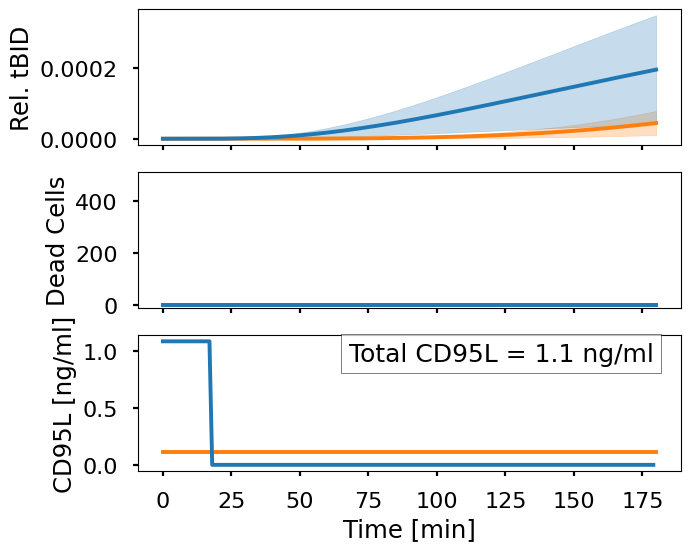

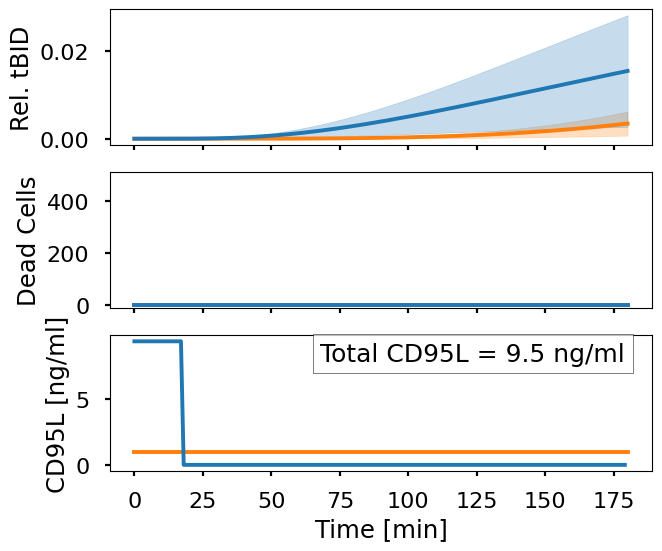

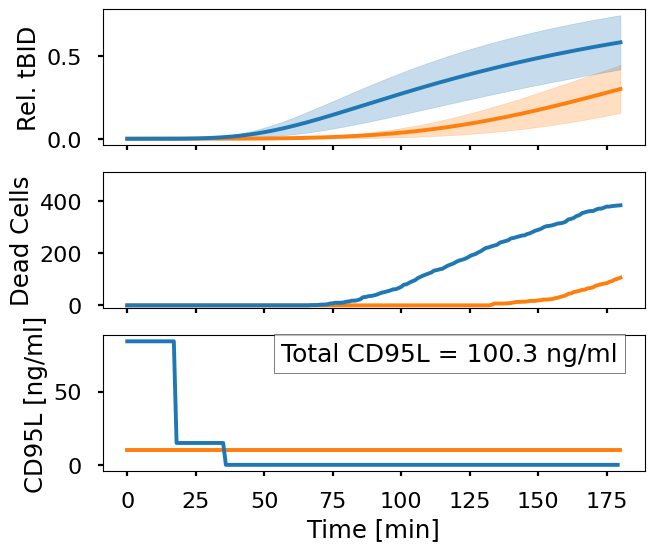

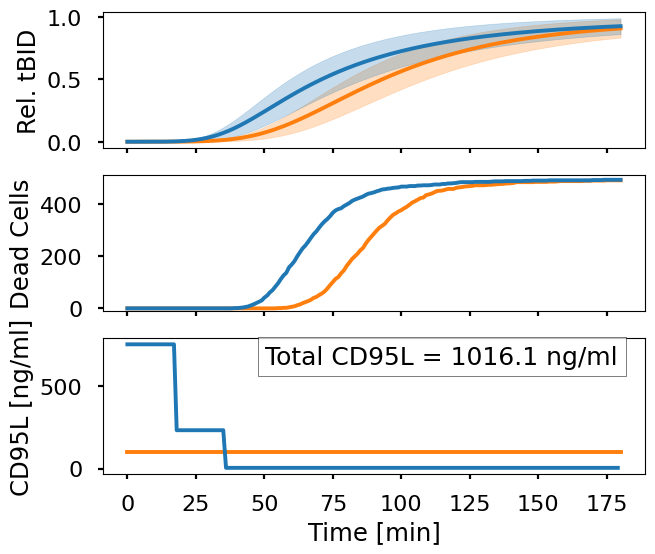

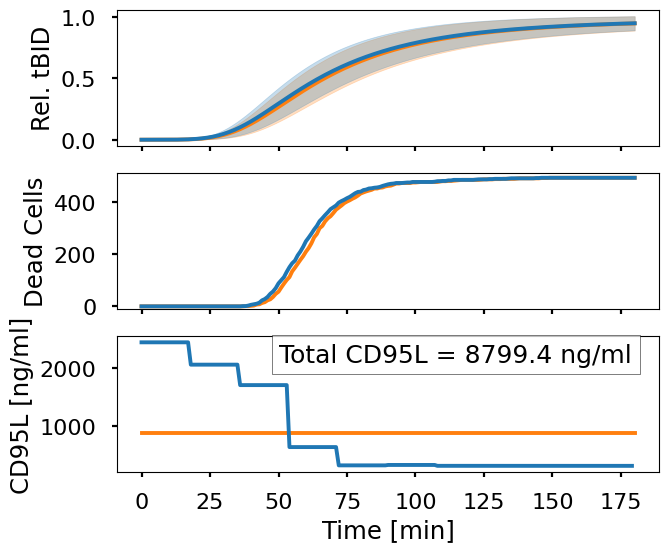

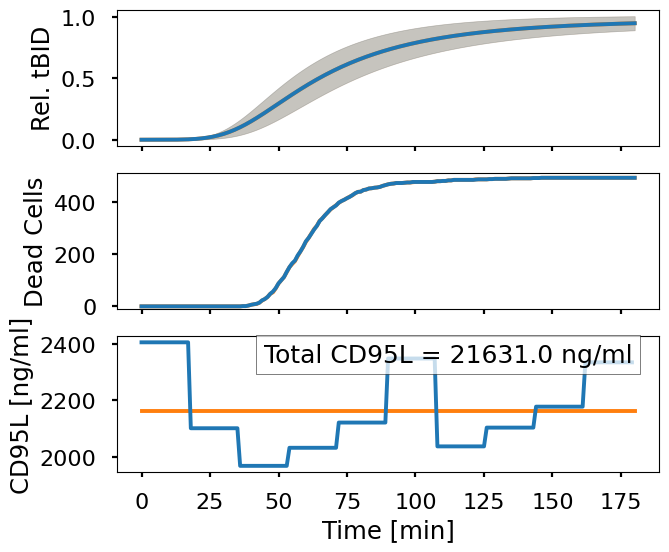

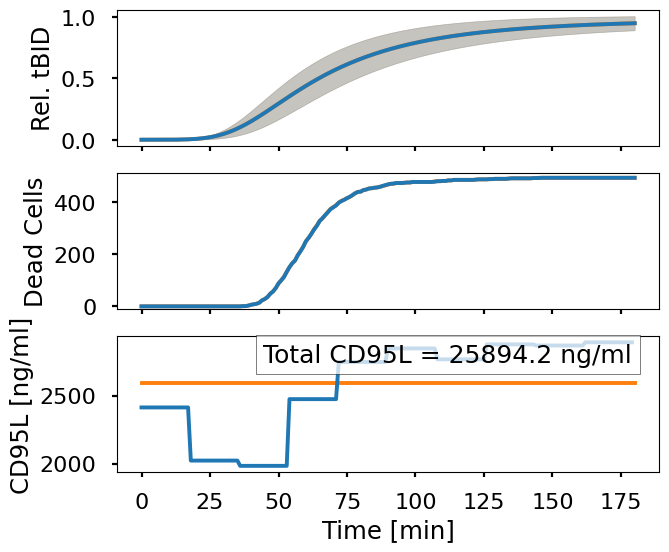

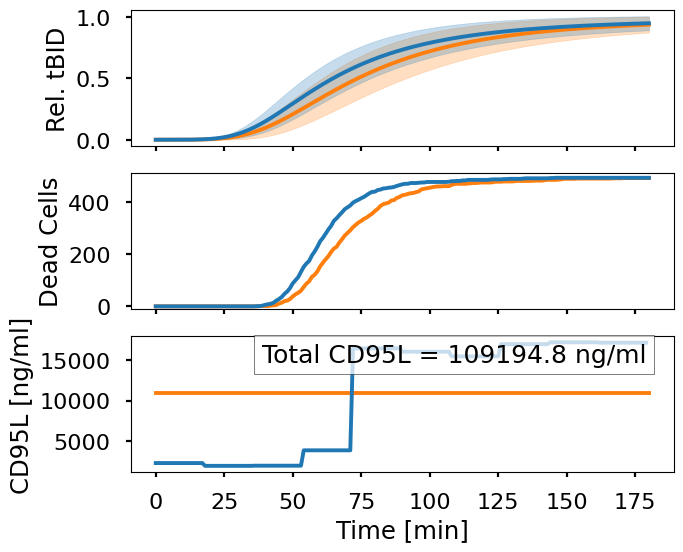

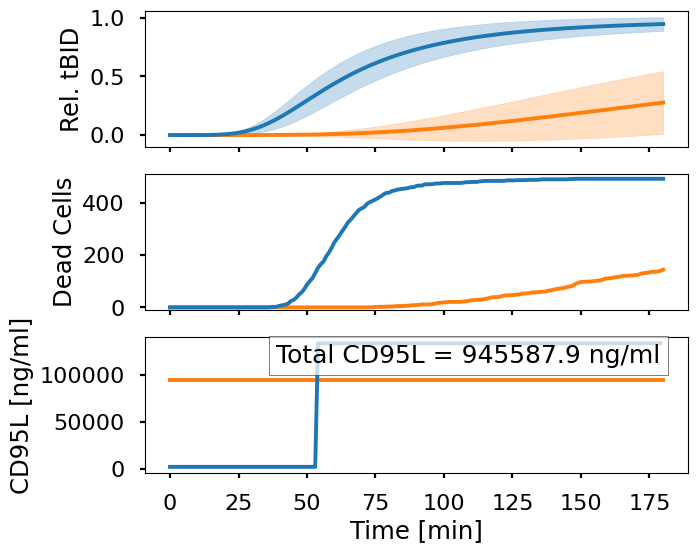

In [76]:
# Individual controls and system states

import scipy.stats


def build_control(
    integral: ArrayLike,
    control: controls.AbstractControl,
) -> controls.AbstractControl:
    constraint = constraints.NonNegativeConstantIntegralConstraint(integral)

    # Evaluate control
    num_points = 10
    points = jnp.linspace(
        # control.t_start, control.t_end, num=num_points, endpoint=False
        0.0,
        180.0,
        num=num_points,
        endpoint=False,
    )
    spacing = 180.0 / num_points
    points += spacing / 2

    # Transform control
    sampled_control = jax.vmap(control)(points.reshape(num_points, 1))
    transformed_control = constraint.transform(sampled_control)

    # Package control
    control = controls.InterpolationControl(
        transformed_control.shape[1],
        transformed_control.shape[0],
        0.0,
        180.0,
        method="step",
        control=transformed_control,
    )

    return control, points, sampled_control, transformed_control


def copy_data(t, c):
    return c


def argfind_closest(values, target):
    return np.argmin(np.abs(values - target))


def tbid_fraction(ys):
    return ys[..., 12] / (ys[..., 3] + ys[..., 12])


def above_threshold(ys, thresh):
    return tbid_fraction(ys) > thresh


with plt.style.context("seaborn-poster"):
    system_time = np.linspace(control.t_start, control.t_end, num=181, endpoint=True)
    control_time = np.linspace(control.t_start, control.t_end, num=10, endpoint=False)

    target_concs = [1e-1, 1e-0, 1e1, 1e2, 1e3, 2e3, 3e3, 1e4, 1e5]
    opt_integrals = np.asarray([r["x"] for r in results])

    for i, target_conc in enumerate(target_concs):
        target_int = np.log10(target_conc / reaction_volume * concentration_to_moles)
        target_idx = argfind_closest(opt_integrals, target_int)

        (
            opt_control,
            opt_points,
            opt_sampled_control,
            opt_transformed_control,
        ) = build_control(
            10 ** opt_integrals[target_idx], results[target_idx]["optimized_control"]
        )

        system_traj, thresh = integrate(opt_control, val_environment, val_env_state)

        relative_fractions = tbid_fraction(system_traj)
        frac_mean = np.mean(relative_fractions, axis=0)
        frac_std = np.std(relative_fractions, axis=0)

        cells_above_thresh = np.sum(
            above_threshold(system_traj, thresh.reshape(-1, 1)), axis=0
        )

        const_control = controls.LambdaControl(lambda t: jnp.ones(2))

        (
            const_control,
            const_points,
            const_sampled_control,
            const_transformed_control,
        ) = build_control(
            10 ** opt_integrals[target_idx],
            const_control,
        )

        const_system_traj, const_thresh = integrate(
            const_control, val_environment, val_env_state
        )

        const_relative_fractions = tbid_fraction(const_system_traj)
        const_frac_mean = np.mean(const_relative_fractions, axis=0)
        const_frac_std = np.std(const_relative_fractions, axis=0)

        const_cells_above_thresh = np.sum(
            above_threshold(const_system_traj, const_thresh.reshape(-1, 1)), axis=0
        )

        fig, ax = plt.subplots(3, 1, sharex=True, figsize=(7, 6))

        # tBID
        ax[0].set_ylabel("Rel. tBID")

        ax[0].fill_between(
            system_time,
            const_frac_mean - const_frac_std,
            const_frac_mean + const_frac_std,
            color="tab:orange",
            alpha=0.25,
        )
        ax[0].plot(
            system_time, np.mean(const_relative_fractions, axis=0), c="tab:orange"
        )

        ax[0].fill_between(
            system_time,
            frac_mean - frac_std,
            frac_mean + frac_std,
            color="tab:blue",
            alpha=0.25,
        )
        ax[0].plot(system_time, np.mean(relative_fractions, axis=0), c="tab:blue")

        # Number of Cells
        ax[1].set_ylabel("Dead Cells")
        ax[1].set_ylim([-10, 510])
        ax[1].plot(system_time, const_cells_above_thresh, c="tab:orange")
        ax[1].plot(system_time, cells_above_thresh, c="tab:blue")

        # Control
        ax[2].set_xlabel("Time [min]")
        ax[2].set_ylabel("CD95L [ng/ml]")
        ax[2].plot(
            system_time[[0, -1]],
            [10 ** opt_integrals[target_idx] * reaction_volume / concentration_to_moles]
            * 2,
            c="tab:orange",
        )
        ax[2].plot(
            system_time[:-1],
            opt_control(system_time[:-1]) * reaction_volume / concentration_to_moles,
            c="tab:blue",
        )

        ax[2].text(
            0.95,
            0.95,
            f"Total CD95L = {10 ** opt_integrals[target_idx] * reaction_volume / concentration_to_moles * 10:.1f} ng/ml",
            horizontalalignment="right",
            verticalalignment="top",
            transform=ax[2].transAxes,
            size=18,
            bbox=dict(boxstyle="square", facecolor="white", alpha=0.75),
        )

        plt.savefig(
            f"../results/apoptosis/poster/piecewise_implicit/individual_trajectories/{i}.png",
            bbox_inches="tight",
        )
        plt.savefig(
            f"../results/apoptosis/poster/piecewise_implicit/individual_trajectories/{i}.svg",
            bbox_inches="tight",
        )
        plt.show()